# Election data 2021 mining

In [2]:
import pandas as pd
import requests
import pathlib

In [3]:
districts_data = pd.read_csv("https://www.volby.cz/opendata/ps2021/csv_od/pst4_csv_od.zip", index_col="ID_OKRSKY")

In [4]:
DATA_DIR = pathlib.Path("./data")
DISTRICTS_FILE = "pst4_csv_od.zip"
DISTRCT_VOTES_FILE = "pst4p_csv_od.zip"
CANDIDATE_REGISTER_FILE = "psrkl.zip"


def _download_data():
    DATA_DIR.mkdir(exist_ok=True)
    if not (DATA_DIR / DISTRICTS_FILE).exists():
        response = requests.get(
            f"https://www.volby.cz/opendata/ps2021/csv_od/{DISTRICTS_FILE}",
            allow_redirects=True,
        )
        with open(DATA_DIR / DISTRICTS_FILE, mode="wb") as data_file:
            data_file.write(response.content)

    if not (DATA_DIR / DISTRCT_VOTES_FILE).exists():
        response = requests.get(
            f"https://www.volby.cz/opendata/ps2021/csv_od/{DISTRCT_VOTES_FILE}",
            allow_redirects=True,
        )
        with open(DATA_DIR / DISTRCT_VOTES_FILE, mode="wb") as data_file:
            data_file.write(response.content)
    if not (DATA_DIR / CANDIDATE_REGISTER_FILE).exists():
        response = requests.get(
            f"https://www.volby.cz/opendata/ps2021/csv_od/{CANDIDATE_REGISTER_FILE}",
            allow_redirects=True,
        )
        with open(DATA_DIR / CANDIDATE_REGISTER_FILE, mode="wb") as data_file:
            data_file.write(response.content)


def get_data(cutoff_percentage=3):
    """
        Function returning election data from CSU, parsed and filtered for usage in MachineLearning

    Args:
        cutoff_percentage (int, optional): What percentage of votes must a party gain to be considered relevant. Defaults to 3.

    Returns:
        pd.DataFrame: Dataframe with percentages of votes for each relevant party (and aggregated others) in each electoral district
    """
    _download_data()
    districts_data = pd.read_csv(
        DATA_DIR / DISTRICTS_FILE,
        index_col="ID_OKRSKY",
        usecols=["ID_OKRSKY", "VOL_SEZNAM", "PL_HL_CELK"],
    )
    district_votes_data = (
        pd.read_csv(
            DATA_DIR / DISTRCT_VOTES_FILE,
            index_col="ID_OKRSKY",
            usecols=["ID_OKRSKY", "KSTRANA", "POC_HLASU"],
        )
        .pivot(columns=["KSTRANA"])
        .fillna(0)
    )
    district_votes_data.columns = district_votes_data.columns.get_level_values(1)
    results = district_votes_data.sum() / districts_data["PL_HL_CELK"].sum()
    relevant_party_votes = district_votes_data[
        results.index[results > cutoff_percentage / 100]
    ]
    other_votes = district_votes_data[
        results.index[~(results > cutoff_percentage / 100)]
    ].sum(axis="columns")
    relevant_party_votes.loc[:, 0] = other_votes
    relevant_party_results = relevant_party_votes.div(
        districts_data["PL_HL_CELK"], axis=0
    )
    relevant_party_results.columns = [
        f"VYSL_{p}" for p in relevant_party_results.columns
    ]
    complete_dataset = districts_data.join(relevant_party_results)
    complete_dataset["VOL_UCAST"] = (
        complete_dataset["PL_HL_CELK"] / complete_dataset["VOL_SEZNAM"]
    )
    complete_dataset = complete_dataset.drop(
        ["VOL_SEZNAM", "PL_HL_CELK"], axis="columns"
    )
    return complete_dataset


In [5]:
results = get_data()

/var/folders/94/9jhx_h1n6xs5cphqnhpmtj540000gp/T/ipykernel_31717/1149821932.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_party_votes.loc[:, 0] = other_votes


In [6]:
results

,VYSL_4,VYSL_5,VYSL_12,VYSL_13,VYSL_17,VYSL_18,VYSL_20,VYSL_0,VOL_UCAST
ID_OKRSKY,,,,,,,,,
1,0.132937,0.055556,0.037698,0.279762,0.126984,0.027778,0.253968,0.085317,0.702929
2,0.109155,0.056338,0.045775,0.292254,0.130282,0.014085,0.264085,0.088028,0.652874
3,0.058824,0.083045,0.031142,0.408304,0.128028,0.020761,0.207612,0.062284,0.733503
4,0.100629,0.050314,0.088050,0.201258,0.138365,0.081761,0.220126,0.119497,0.593284
5,0.179204,0.050885,0.042035,0.250000,0.081858,0.015487,0.307522,0.073009,0.620027
...,...,...,...,...,...,...,...,...,...
14882,0.000000,0.000000,0.000000,0.375000,0.541667,0.000000,0.000000,0.083333,0.750000
14883,0.052632,0.017544,0.263158,0.298246,0.105263,0.000000,0.070175,0.192982,0.791667
14884,0.000000,0.040000,0.200000,0.160000,0.120000,0.000000,0.440000,0.040000,1.000000


# Clustering

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [8]:
features = ['VYSL_4', 'VYSL_5', 'VYSL_12', 'VYSL_13', 'VYSL_17', 'VYSL_18', 'VYSL_20', 'VYSL_0']

/opt/homebrew/Caskroom/miniforge/base/envs/data_mining/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/data_mining/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/data_mining/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/data_mining/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

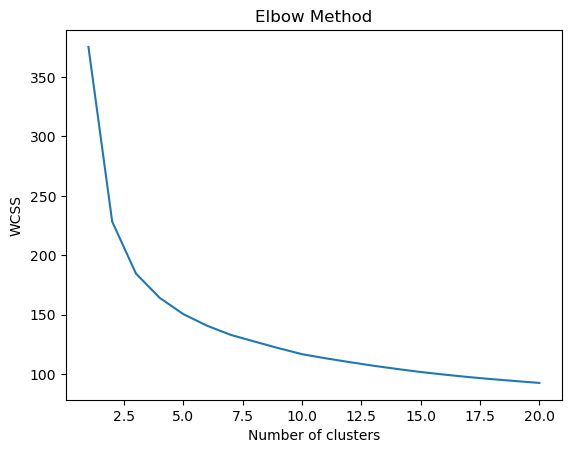

In [9]:
MAX_CLUSTERS = 20

# Compute the within-cluster sum of squares (WCSS) for different values of k
wcss = []
for k in range(1, MAX_CLUSTERS + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(results[features])
    wcss.append(kmeans.inertia_)

# Plot the WCSS as a function of the number of clusters
plt.plot(range(1, MAX_CLUSTERS + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [11]:
CLUSTERS = 10

kmeans = KMeans(n_clusters=CLUSTERS)
kmeans.fit(results[features])
results['cluster'] = kmeans.labels_
print(results.groupby('cluster')[features].mean())

/opt/homebrew/Caskroom/miniforge/base/envs/data_mining/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


           VYSL_4    VYSL_5   VYSL_12   VYSL_13   VYSL_17   VYSL_18   VYSL_20   
cluster                                                                         
0        0.093241  0.050102  0.046468  0.198405  0.219127  0.040539  0.281507  \
1        0.078277  0.045407  0.045438  0.313977  0.200542  0.031009  0.216037   
2        0.100548  0.052194  0.049368  0.218016  0.116494  0.046021  0.346793   
3        0.145637  0.056791  0.058312  0.222103  0.120026  0.053182  0.254625   
4        0.078377  0.047867  0.045053  0.386916  0.130260  0.032275  0.212813   
5        0.115017  0.047435  0.043177  0.136709  0.090480  0.050017  0.452407   
6        0.090410  0.052319  0.050123  0.290573  0.128333  0.038629  0.279876   
7        0.037695  0.028789  0.021884  0.287504  0.478071  0.008810  0.073240   
8        0.170595  0.048005  0.048344  0.145148  0.104880  0.054393  0.350024   
9        0.046081  0.033301  0.030965  0.424126  0.248777  0.016791  0.142091   

           VYSL_0  
cluster